# Import all packages

In [1]:
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import unidecode as unidecode

import spacy
from spacy.matcher import Matcher
from spacy.lang.en.stop_words import STOP_WORDS
from spacy import displacy
from spacy.matcher import Matcher
import textacy 
from gensim.models import FastText
from gensim.test.utils import get_tmpfile
from gensim.utils import tokenize
import gensim.downloader as api
from tqdm.notebook import tqdm_notebook
import pickle

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

In [2]:
nlp = spacy.load("en_core_web_sm", parse=True, tag=True, entity=True)

# Load documents 
Load in metadata.csv, note that all the meta data are clean by following:

<b>Metadata clean</b>
- Removing abstract that doesn't contain information.
- Combining title and abstract into single column
- Calculate document vectors using FastText, load "glove-wiki-gigaword-50" model

    - Note that this document model can be change e.g. more complex model, or use ELMO or BERT.
    
    - "df_vectors" should be recomputed when model is changed.
    
<b>Metadata vector</b>
- Calculate similarity vectors between documents
- Using this similarity vectors to form knowledge graph
- Using knowledge graph to find:
    - Degree centrality: Measures number of incoming connections, nodes with highest connection are important ones
    - Closeness Centrality: Measures minimum numbers of steps can one nodes connect to others in the network
    - EigenVector Centrality: Measures a node connection to those who are highly connected. Influencing nodes and exercising control
    - Betweenness Centrality: Measure of centrality in a graph based on shortest paths. Bridge Nodes, how important node is to the shortest path through the network. 
    
    

In [2]:
# Load CSV clean and vectors 
df = pd.read_csv(os.path.join("Corpus", "metadata_clean.csv"))
df_vectors = pd.read_csv(os.path.join("Corpus", "metadata_vectors.csv"))

print(f"Total number of documents: {df.shape}")
print(f"Vectors shape: {df_vectors.shape}")

Total number of documents: (35151, 3)
Vectors shape: (35151, 50)


# Loading model and functions

In [52]:
def contain_word(word):
    return word in model.vocab.keys()

def sentence_vector(sentence, negative=None, positive=None):
    """
    Use either negative or positive sentences to guide sentence vector
    """
    if negative:
        negative = list(tokenize(negative))
        negative = [word for word in negative if word not in sentence]
        # print(negative)
        neg_vectors = [model[word] for word in negative if contain_word(word)]
        
        # tokenize sentence, we need sentence as a string to extract additional words in negative
        sentence = list(tokenize(sentence))
        vectors = [model[word] for word in sentence if contain_word(word)]
        vectors = np.mean(vectors, axis=0)
        
        if len(neg_vectors) == 0:
            neg_vectors = np.zeros(vectors.shape)
                   
        return vectors - np.mean(neg_vectors, axis=0)
    
    elif positive:
        positive = list(tokenize(positive))
        positive = [word for word in positive if word not in sentence]
        # print(positive)
        pos_vectors = [model[word] for word in positive if contain_word(word)]
        
        # tokenize sentence, we need sentence as a string to extract additional words in positive
        sentence = list(tokenize(sentence))
        vectors = [model[word] for word in sentence if contain_word(word)]
        vectors = np.mean(vectors, axis=0)
        
        if len(pos_vectors) == 0:
            pos_vectors = np.zeros(vectors.shape)
        
        return vectors + np.mean(pos_vectors, axis=0)
    
    else:
        sentence = list(tokenize(sentence))
        vectors = [model[word] for word in sentence if contain_word(word)]
        return np.mean(vectors, axis=0)

def jaccard_similarity(query, document):
    intersection = set(query).intersection(set(document))
    union = set(query).union(set(document))
    return len(intersection)/len(union)

def search_doc(query, context=None, top_n=100):
    query_vector = sentence_vector(query, positive=context)
    result = model.cosine_similarities(query_vector, df_vectors.values)
    df['score'] = result 
    return df.sort_values('score', ascending=False)[:top_n]


In [5]:
model = api.load("glove-wiki-gigaword-50", return_path=False)

# Building knowledge graph through query sentence

## Query sentence compute distance score with all content
"search_doc" function is design to allow users to add context to search query. It allow us to guide the vector towards a certain direction.

In exmaple following query:
- Computer virus is infecting every city. context="digital"
- Coronavirus is infecting every city. context="biology"

Because our model does not know the new word coronavirus, we can provide context to the search. The result will be more accurate than the query alone.


In [53]:
# result_df = search_doc("Implementation of diagnostic and products to improve clinical processes.", context="medical, pneumonia", top_n=300)
result_df = search_doc("New diagnostic methods and products to improve clinical processes.", context="medical, pneumonia, novel", top_n=1000)
result_df

,title,abstract,content,score
12570,Clinical analysis of 2019 coronavirus disease ...,Objective To analyze the clinical characterist...,Clinical analysis of 2019 coronavirus disease ...,0.937140
1554,Chapter 5 Laboratory Diagnosis of Viral Infect...,This chapter describes methods of laboratory d...,Chapter 5 Laboratory Diagnosis of Viral Infect...,0.935598
12400,Diagnosis and clinical management of 2019 nove...,"Since December 2019, China has been experienci...",Diagnosis and clinical management of 2019 nove...,0.935057
8190,Equine Infectious Anemia.,This article describes clinical signs and tran...,Equine Infectious Anemia. This article describ...,0.933950
3034,Pneumonia in pediatric outpatients: Cause and ...,The cause and clinical manifestations of pneum...,Pneumonia in pediatric outpatients: Cause and ...,0.932352
8187,Recent Advances in the Laboratory Diagnosis of...,This article reviews recent advances in labora...,Recent Advances in the Laboratory Diagnosis of...,0.928651
11723,Clinical imaging research of the first Middle ...,Middle East respiratory syndrome is a viral re...,Clinical imaging research of the first Middle ...,0.926428
827,Applications of nucleic acid probes in veterin...,Nucleic acid probe technology is increasingly ...,Applications of nucleic acid probes in veterin...,0.924757
12418,Novel coronavirus pneumonia related liver inju...,The outbreak of novel coronavirus pneumonia(NC...,Novel coronavirus pneumonia related liver inju...,0.923968
21144,Bench-to-bedside review: Rare and common viral...,Viral infections are common causes of respirat...,Bench-to-bedside review: Rare and common viral...,0.923319


## Calculate the edges
Each id is a document, edges is how closely the document is related to one another.

We are using min-max scaler because the document is already closely related by using min-max scaler minor different will scale up. 

The purpose is to further group them and see there are any nodes cluster to be found. We can later use centrality algorithm to further find import links between these documents.

In [54]:
from sklearn import preprocessing

In [55]:
dis_matrix = []

# Filter selected vectors
df_result_vectors = df_vectors.iloc[result_df.index]

# Compute similarity vector matrix against each document
for idx, row in tqdm_notebook(df_result_vectors.iterrows(), total=len(df_result_vectors)):
    row = list(row)
    result = model.cosine_similarities(row, df_result_vectors)
    dis_matrix.append(result)
    
# Scale the result 
min_max_scaler = preprocessing.MinMaxScaler()
dis_matrix = min_max_scaler.fit_transform(dis_matrix)
dis_matrix_df = pd.DataFrame(dis_matrix)

# Adding IDs for easy reference
dis_matrix_df.columns = result_df.index
dis_matrix_df.insert(0, 'id', result_df.index)
dis_matrix_df

,id,12570,1554,12400,8190,3034,8187,11723,827,12418,...,11883,3204,20862,32799,20863,21420,12946,21500,33740,9446
0,12570,1.000000,0.595924,0.675846,0.496152,0.842555,0.561672,0.695989,0.538405,0.689013,...,0.744859,0.513607,0.766846,0.632807,0.772325,0.730735,0.485350,0.687420,0.502458,0.730985
1,1554,0.395052,1.000000,0.344967,0.594984,0.559513,0.340322,0.531894,0.499432,0.304399,...,0.000000,0.275677,0.096725,0.191143,0.000000,0.304078,0.306838,0.284627,0.147938,0.145263
2,12400,0.694405,0.587521,1.000000,0.630173,0.706736,0.562915,0.838480,0.447868,0.832231,...,0.632286,0.719309,0.665982,0.482809,0.698205,0.668746,0.412073,0.710782,0.534394,0.662952
3,8190,0.398770,0.677181,0.531892,1.000000,0.504332,0.525347,0.520169,0.476541,0.399787,...,0.115840,0.484734,0.240040,0.278785,0.293959,0.285074,0.362363,0.371264,0.352292,0.228126
4,3034,0.813072,0.650680,0.630673,0.506831,1.000000,0.500239,0.714174,0.486083,0.575695,...,0.674411,0.490042,0.656542,0.482012,0.673409,0.724156,0.396345,0.752449,0.461486,0.637460
5,8187,0.501790,0.499170,0.473031,0.547886,0.521558,1.000000,0.624645,0.638877,0.472886,...,0.557339,0.740978,0.376483,0.510510,0.449834,0.486291,0.601762,0.414170,0.652824,0.364671
6,11723,0.668829,0.659394,0.813364,0.561964,0.737748,0.640257,1.000000,0.470937,0.721346,...,0.673909,0.699565,0.630070,0.430727,0.652864,0.705524,0.478671,0.675651,0.606071,0.563831
7,827,0.479551,0.623014,0.339662,0.505395,0.511950,0.641773,0.452403,1.000000,0.341028,...,0.277558,0.488936,0.159202,0.572630,0.206255,0.386579,0.674864,0.442514,0.591599,0.323887
8,12418,0.679159,0.520650,0.816403,0.481066,0.631294,0.521547,0.736094,0.397028,1.000000,...,0.550028,0.668849,0.579504,0.464740,0.640877,0.590884,0.461835,0.690233,0.503791,0.617730
9,21144,0.755800,0.603204,0.781858,0.602811,0.725395,0.700874,0.730786,0.624611,0.815753,...,0.687797,0.741718,0.640401,0.726634,0.736881,0.634543,0.710259,0.723136,0.674826,0.717493


## Filter out edges 
Filter out similarity vectors that are above our threshold. We will want to reduce the number of connections between each nodes.

End result: {node1: [edge1, edge2]}

In [67]:
threshold = 0.8
connections = {}
id_list = dis_matrix_df['id']

for _, row in tqdm_notebook(dis_matrix_df.iterrows(), total=len(dis_matrix_df)):
    connectToIds = []
    cur_id = int(row.values[0])

    # filter out edge that met our threshold
    for idx, v in zip(id_list, row.values[1:]):
        if v < 1.0 and v > threshold:
            connectToIds.append(idx)
            
    # matching cur id to connected id
    connections[cur_id] = connectToIds 
print(connections)


{12570: [3034, 7954, 12313, 16725, 7961, 9278, 10730, 6977, 16304, 11753, 31586, 11502, 25012, 20135, 19293, 12604, 26036, 1154, 1698, 2577, 12587, 8241], 1554: [], 12400: [11723, 12418, 12213, 33472, 12469, 12279], 8190: [], 3034: [12570, 16725, 7961, 32642, 3022, 21957, 21032, 11753, 19973, 21895, 20974, 25403, 20938, 25012, 20567, 9952, 6370, 10307], 8187: [2019, 4661, 23655, 10221, 32356, 1397, 20454, 6213, 21787, 6792, 22170, 24212, 23257, 12232, 22596, 13439, 22166, 13344, 22835, 9512, 28879, 10643, 24976, 20990, 1753, 1072, 25493, 24579, 5813, 23617, 9508, 9623, 33360, 9448, 27386, 23985, 11151, 20345, 9724, 5557, 1868, 20476, 15899, 16901, 2493, 12703, 4430, 17990, 11551, 11227, 4867, 1366, 25366, 12026, 23054, 10928, 8365, 9634, 1446, 30814, 24439, 34088, 29542, 8102, 10343, 21604, 23230, 21654], 11723: [12400, 33885, 23655, 11971, 12213, 35062, 33472, 10452, 20332, 9487, 10763, 12068, 32166], 827: [10221, 4432, 10798, 21200], 12418: [12400, 12222, 9447, 12469, 12279], 21144:

## Forming nodes and edges

In [13]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [68]:
G = nx.Graph()
G.clear()

for achorEvent in tqdm_notebook(connections.keys()):
    for _, eventid in enumerate(connections[achorEvent]):
        # Adding by nodes and edges
        G.add_edge(achorEvent, eventid)
        
print(nx.info(G))


Name: 
Type: Graph
Number of nodes: 986
Number of edges: 78615
Average degree: 159.4625


## First view of covid exploration

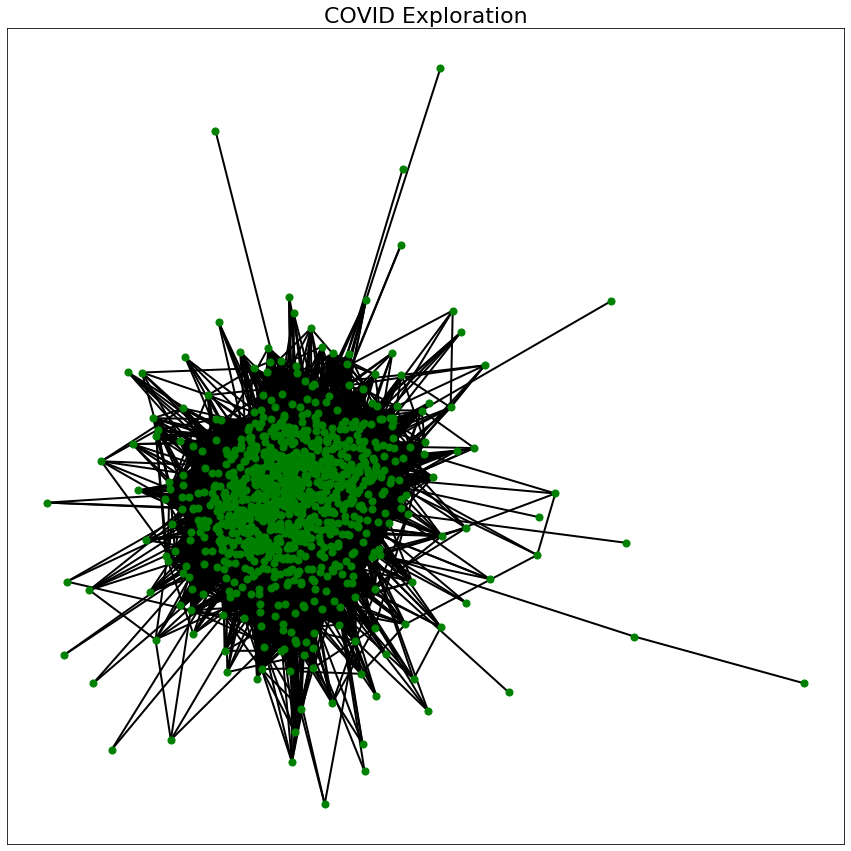

In [69]:
pos = nx.spring_layout(G)

fig, ax = plt.subplots(figsize=(15, 15))
plt.title("COVID Exploration", fontsize=22, fontname='DejaVu Sans')
nx.draw_networkx_nodes(G, pos, node_size=50, node_color='green')
nx.draw_networkx_edges(G, pos, width=2.0)
plt.show()

## Degree Centrality
Measure number of incoming connections.

The higher the connection means the article is important.

[(22362, 0.5126903553299492), (15498, 0.49137055837563454), (17970, 0.484263959390863), (22231, 0.4720812182741117), (11773, 0.45989847715736043), (1442, 0.4588832487309645), (10350, 0.4406091370558376), (32634, 0.43959390862944164), (18277, 0.4385786802030457), (14356, 0.4324873096446701)]


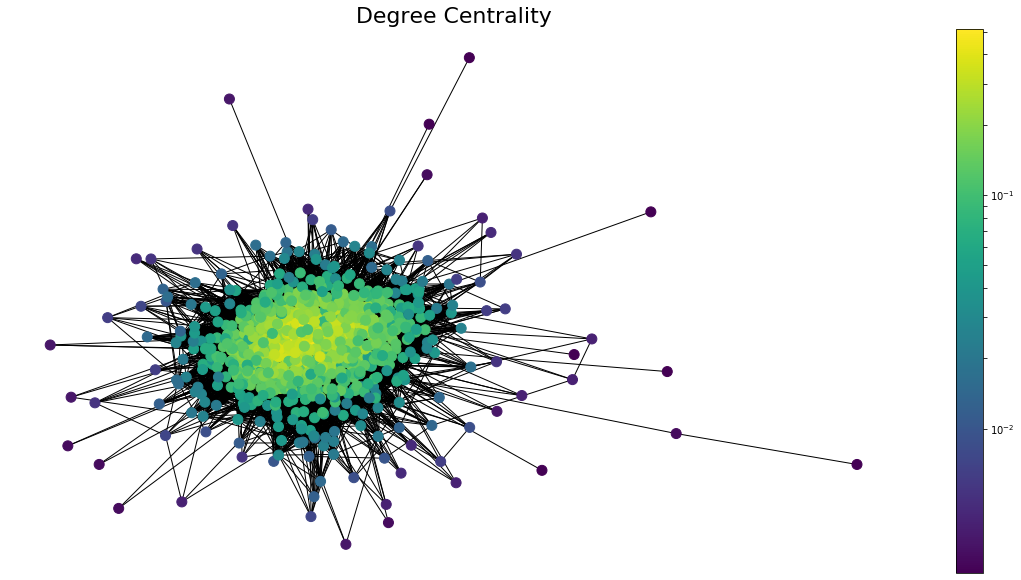

In [70]:
from collections import Counter
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
%matplotlib inline

# Function to plot the graphs for each centrality metric
def draw(G, pos, lista, listb, measure_name):
    fig, ax = plt.subplots(figsize=(20, 10))
    nodes=nx.draw_networkx_nodes(G, pos, node_size=100, cmap=plt.cm.viridis,node_color=lista,nodelist=listb)
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
    edges=nx.draw_networkx_edges(G, pos)
    plt.title(measure_name, fontsize=22, fontname='DejaVu Sans')
    plt.colorbar(nodes)
    plt.axis('off')

dict_degree_centrality = nx.degree_centrality(G)
dict(Counter(dict_degree_centrality).most_common(10))

# dict_closeness_centrality = nx.closeness_centrality(G)
# dict(Counter(dict_closeness_centrality).most_common(10))

list_pos_values = []
for i in dict_degree_centrality.values():
    list_pos_values.append(i)

list_pos_keys=[]
for i in dict_degree_centrality.keys():
    list_pos_keys.append(i)
    
draw(G, pos, list_pos_values, list_pos_keys, 'Degree Centrality')
print(Counter(dict_degree_centrality).most_common(10))

In [33]:
# Looking at articles with the most importances
def view_articles(articles):
    keys = [item[0] for item in articles]
    degree_scores = [item[1] for item in articles]
    degreeCent_df = result_df.loc[keys]
    degreeCent_df['degree score'] = degree_scores
    return degreeCent_df.sort_values(by='degree score', ascending=False)

In [71]:
degreeCent_df = view_articles(Counter(dict_degree_centrality).most_common(10))
degreeCent_df

,title,abstract,content,score,degree score
22362,Viral infection in community acquired pneumoni...,BACKGROUND: Patients with community acquired p...,Viral infection in community acquired pneumoni...,0.906189,0.512690
15498,How to approach and treat viral infections in ...,Patients with severe viral infections are ofte...,How to approach and treat viral infections in ...,0.910064,0.491371
17970,Respiratory virus of severe pneumonia in South...,BACKGROUND: Severe viral pneumonia is associat...,Respiratory virus of severe pneumonia in South...,0.908447,0.484264
22231,Prophylactic and therapeutic approaches for hu...,Human metapneumovirus (HMPV) is an important p...,Prophylactic and therapeutic approaches for hu...,0.896975,0.472081
11773,Rapid diagnostic test for respiratory infections.,Acute respiratory infections are the second ca...,Rapid diagnostic test for respiratory infectio...,0.904213,0.459898
1442,Chapter 9 Gene Therapy for Respiratory Viral I...,Pulmonary infections by viruses may result in ...,Chapter 9 Gene Therapy for Respiratory Viral I...,0.907425,0.458883
10350,Using a novel rapid viral test to improve tria...,Background Acute respiratory illnesses (ARI) a...,Using a novel rapid viral test to improve tria...,0.896567,0.440609
32634,Middle East Respiratory Syndrome Coronavirus I...,Middle East respiratory syndrome coronavirus (...,Middle East Respiratory Syndrome Coronavirus I...,0.908895,0.439594
18277,Viral Respiratory Infections in the Neonatal I...,"Although infrequent, respiratory viral infecti...",Viral Respiratory Infections in the Neonatal I...,0.894635,0.438579
14356,Fourth European Conference on Infections in Le...,Community-acquired respiratory virus (CARV) in...,Fourth European Conference on Infections in Le...,0.896031,0.432487


In [72]:
for idx, row in degreeCent_df.iterrows():
    print(row['title'])
    print(row['abstract'])
    print()

Viral infection in community acquired pneumonia patients with fever: a prospective observational study.
BACKGROUND: Patients with community acquired pneumonia (CAP) caused by viruses can develop severe complications, which result in hospitalization and death. The purpose of this study was to analyse the aetiology, incidence, clinical characteristics, and outcomes of CAP patients with fever during non-pandemics, and then to provide theoretical basis for accurate diagnosis and treatment in CAP patients. METHODS: An enrolment system was established for monitoring the CAP patients with fever. Multiplex polymerase chain reaction (mPCR) kits were used to detect 10 viruses [influenza A and B, adenovirus (ADV), respiratory syncytial virus (RSV) A and B, picornavirus, parainfluenza virus (PIV), coronavirus, human metapneumovirus (HMPV), and bocavirus]. Data on age, gender, underlying diseases, complications, laboratory indexes, and outcomes were collected by physicians. RESULTS: This prospectiv

## Closeness Centrality

[(22362, 0.6597454789015406), (15498, 0.655792276964048), (17970, 0.6480263157894737), (22231, 0.6429503916449086), (1442, 0.6408588158750813), (11773, 0.6396103896103896), (10350, 0.6265903307888041), (18277, 0.6265903307888041), (27377, 0.6242078580481623), (32634, 0.6238125395820139)]


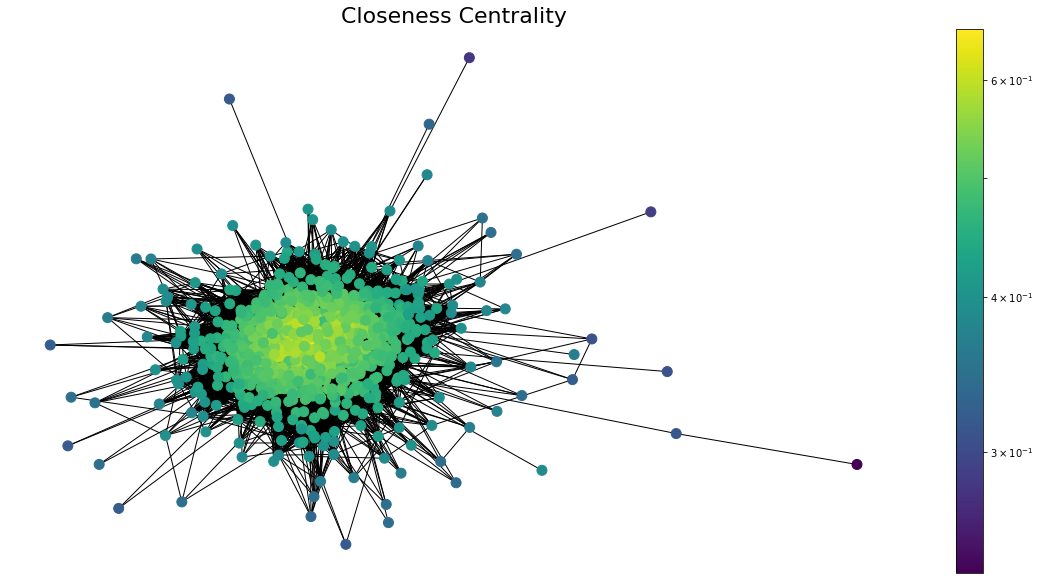

In [73]:
dict_closeness_centrality = nx.closeness_centrality(G)
dict(Counter(dict_closeness_centrality).most_common(10))

list_pos_values = []
for i in dict_closeness_centrality.values():
    list_pos_values.append(i)

list_pos_keys=[]
for i in dict_closeness_centrality.keys():
    list_pos_keys.append(i)
    
draw(G, pos, list_pos_values, list_pos_keys, 'Closeness Centrality')
print(Counter(dict_closeness_centrality).most_common(10))

In [74]:
closenessCent_df = view_articles(Counter(dict_closeness_centrality).most_common(10))
closenessCent_df

,title,abstract,content,score,degree score
22362,Viral infection in community acquired pneumoni...,BACKGROUND: Patients with community acquired p...,Viral infection in community acquired pneumoni...,0.906189,0.659745
15498,How to approach and treat viral infections in ...,Patients with severe viral infections are ofte...,How to approach and treat viral infections in ...,0.910064,0.655792
17970,Respiratory virus of severe pneumonia in South...,BACKGROUND: Severe viral pneumonia is associat...,Respiratory virus of severe pneumonia in South...,0.908447,0.648026
22231,Prophylactic and therapeutic approaches for hu...,Human metapneumovirus (HMPV) is an important p...,Prophylactic and therapeutic approaches for hu...,0.896975,0.642950
1442,Chapter 9 Gene Therapy for Respiratory Viral I...,Pulmonary infections by viruses may result in ...,Chapter 9 Gene Therapy for Respiratory Viral I...,0.907425,0.640859
11773,Rapid diagnostic test for respiratory infections.,Acute respiratory infections are the second ca...,Rapid diagnostic test for respiratory infectio...,0.904213,0.639610
10350,Using a novel rapid viral test to improve tria...,Background Acute respiratory illnesses (ARI) a...,Using a novel rapid viral test to improve tria...,0.896567,0.626590
18277,Viral Respiratory Infections in the Neonatal I...,"Although infrequent, respiratory viral infecti...",Viral Respiratory Infections in the Neonatal I...,0.894635,0.626590
27377,The Challenge of Respiratory Virus Infections ...,Respiratory virus infections in hematopoietic ...,The Challenge of Respiratory Virus Infections ...,0.904661,0.624208
32634,Middle East Respiratory Syndrome Coronavirus I...,Middle East respiratory syndrome coronavirus (...,Middle East Respiratory Syndrome Coronavirus I...,0.908895,0.623813


## Eigenvector Centrality

[(22362, 0.08027524200440214), (17970, 0.07826349544511325), (11773, 0.07632979492744044), (22231, 0.07618377197791835), (10350, 0.07496520730227213), (32634, 0.07473944668639135), (18277, 0.07445180127655059), (9674, 0.0742078502375081), (15498, 0.07403928125991717), (17367, 0.07331733792125282)]


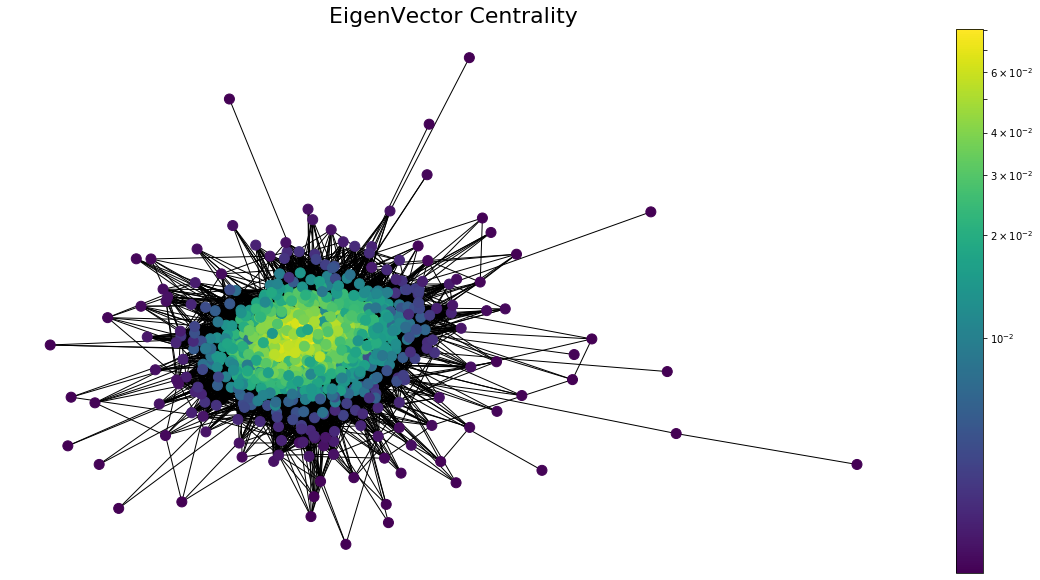

In [75]:
dict_eigenvector_centrality = nx.eigenvector_centrality(G)
dict(Counter(dict_eigenvector_centrality).most_common(10))

list_pos_values = []
for i in dict_eigenvector_centrality.values():
    list_pos_values.append(i)

list_pos_keys=[]
for i in dict_eigenvector_centrality.keys():
    list_pos_keys.append(i)
    
draw(G, pos, list_pos_values, list_pos_keys, 'EigenVector Centrality')
print(Counter(dict_eigenvector_centrality).most_common(10))

In [76]:
eigenCent_df = view_articles(Counter(dict_eigenvector_centrality).most_common(10))
eigenCent_df

,title,abstract,content,score,degree score
22362,Viral infection in community acquired pneumoni...,BACKGROUND: Patients with community acquired p...,Viral infection in community acquired pneumoni...,0.906189,0.080275
17970,Respiratory virus of severe pneumonia in South...,BACKGROUND: Severe viral pneumonia is associat...,Respiratory virus of severe pneumonia in South...,0.908447,0.078263
11773,Rapid diagnostic test for respiratory infections.,Acute respiratory infections are the second ca...,Rapid diagnostic test for respiratory infectio...,0.904213,0.076330
22231,Prophylactic and therapeutic approaches for hu...,Human metapneumovirus (HMPV) is an important p...,Prophylactic and therapeutic approaches for hu...,0.896975,0.076184
10350,Using a novel rapid viral test to improve tria...,Background Acute respiratory illnesses (ARI) a...,Using a novel rapid viral test to improve tria...,0.896567,0.074965
32634,Middle East Respiratory Syndrome Coronavirus I...,Middle East respiratory syndrome coronavirus (...,Middle East Respiratory Syndrome Coronavirus I...,0.908895,0.074739
18277,Viral Respiratory Infections in the Neonatal I...,"Although infrequent, respiratory viral infecti...",Viral Respiratory Infections in the Neonatal I...,0.894635,0.074452
9674,The significance of rhinovirus detection in ho...,Recent developments in molecular diagnostic to...,The significance of rhinovirus detection in ho...,0.902231,0.074208
15498,How to approach and treat viral infections in ...,Patients with severe viral infections are ofte...,How to approach and treat viral infections in ...,0.910064,0.074039
17367,Respiratory viral infections are underdiagnose...,The study aim was to investigate the prevalenc...,Respiratory viral infections are underdiagnose...,0.901925,0.073317


## Betweeness Centrality

In [39]:
from multiprocessing import Pool
import itertools

In [77]:
def partitions(nodes, n):
    "Partitions the nodes into n subsets"
    nodes_iter = iter(nodes)
    while True:
        partition = tuple(itertools.islice(nodes_iter,n))
        if not partition:
            return
        yield partition
        
def btwn_pool(G_tuple):
    return nx.betweenness_centrality_source(*G_tuple)

def partitions(nodes, n):
    "Partitions the nodes into n subsets"
    nodes_iter = iter(nodes)
    while True:
        partition = tuple(itertools.islice(nodes_iter,n))
        if not partition:
            return
        yield partition
        
# To begin the parallel computation, we initialize a Pool object with the
# number of available processors on our hardware. We then partition the
# network based on the size of the Pool object (the size is equal to the 
# number of available processors). 
def between_parallel(G, processes = None):
    p = Pool(processes=processes)
    part_generator = 4*len(p._pool)
    node_partitions = list(partitions(G.nodes(), int(len(G)/part_generator)))
    num_partitions = len(node_partitions)
 
    #Next, we pass each processor a copy of the entire network and 
    #compute #the betweenness centrality for each vertex assigned to the 
    #processor.
 
    bet_map = p.map(btwn_pool,
                    zip([G]*num_partitions,
                        [True]*num_partitions,
                        [None]*num_partitions,
                        node_partitions))
 
    #Finally, we collect the betweenness centrality calculations from each 
    #pool and aggregate them together to compute the overall betweenness 
    #centrality score for each vertex in the network.
 
    bt_c = bet_map[0]
    for bt in bet_map[1:]:
        for n in bt:
            bt_c[n] += bt[n]
    return bt_c

Finding Betweenness Centrality in parallel...


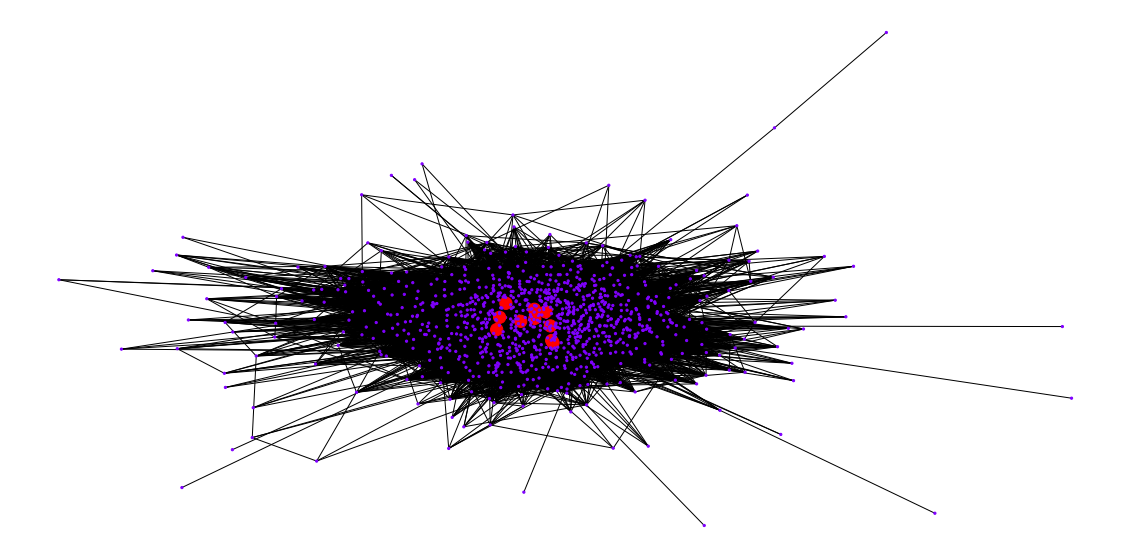

In [78]:
# print(nx.info(G))
print("Finding Betweenness Centrality in parallel...")

#Create network layout for visualizations
spring_pos = nx.spring_layout(G)
bt = between_parallel(G)
top = 10

max_nodes = sorted(bt.items(), key=lambda k:k[1])[-top:]
bt_values = [5]*len(G.nodes())
bt_colors = [0]*len(G.nodes())

max_ids = [i[0] for i in max_nodes]
for idx, eventid in enumerate(bt.keys()):
    if eventid in max_ids:
        bt_values[idx] = 150
        bt_colors[idx] = 2

fig, ax = plt.subplots(figsize=(20, 10))
plt.axis("off")
nx.draw_networkx(G, pos = spring_pos, cmap = plt.get_cmap("rainbow"), node_color = bt_colors, node_size = bt_values, with_labels = False)

In [79]:
result_df.loc[list(max_ids)]

,title,abstract,content,score
22231,Prophylactic and therapeutic approaches for hu...,Human metapneumovirus (HMPV) is an important p...,Prophylactic and therapeutic approaches for hu...,0.896975
18529,Respiratory Virus Infections in Hematopoietic ...,Highly immunocompromised pediatric and adult h...,Respiratory Virus Infections in Hematopoietic ...,0.899145
19648,Molecular Diagnosis of Pneumonia Using Multipl...,"BACKGROUND: In Morocco, pediatric pneumonia re...",Molecular Diagnosis of Pneumonia Using Multipl...,0.906769
1072,Chapter 54 Antibiotics.,Publisher Summary This chapter discusses the b...,Chapter 54 Antibiotics. Publisher Summary This...,0.904078
17970,Respiratory virus of severe pneumonia in South...,BACKGROUND: Severe viral pneumonia is associat...,Respiratory virus of severe pneumonia in South...,0.908447
27377,The Challenge of Respiratory Virus Infections ...,Respiratory virus infections in hematopoietic ...,The Challenge of Respiratory Virus Infections ...,0.904661
22170,Practical Guidance for Clinical Microbiology L...,Respiratory viral infections are associated wi...,Practical Guidance for Clinical Microbiology L...,0.911660
22362,Viral infection in community acquired pneumoni...,BACKGROUND: Patients with community acquired p...,Viral infection in community acquired pneumoni...,0.906189
15498,How to approach and treat viral infections in ...,Patients with severe viral infections are ofte...,How to approach and treat viral infections in ...,0.910064
1442,Chapter 9 Gene Therapy for Respiratory Viral I...,Pulmonary infections by viruses may result in ...,Chapter 9 Gene Therapy for Respiratory Viral I...,0.907425
